In [14]:
using DSP, FFTW

def stft(
    y,
    n_fft=2048,
    hop_length=None,
    win_length=None,
    window="hann",
    center=True,
    dtype=None,
    pad_mode="reflect",
):
    """Short-time Fourier transform (STFT).

    The STFT represents a signal in the time-frequency domain by
    computing discrete Fourier transforms (DFT) over short overlapping
    windows.

    This function returns a complex-valued matrix D such that

    - ``np.abs(D[f, t])`` is the magnitude of frequency bin ``f``
      at frame ``t``, and

    - ``np.angle(D[f, t])`` is the phase of frequency bin ``f``
      at frame ``t``.

    The integers ``t`` and ``f`` can be converted to physical units by means
    of the utility functions `frames_to_sample` and `fft_frequencies`.


    Parameters
    ----------
    y : np.ndarray [shape=(n,)], real-valued
        input signal

    n_fft : int > 0 [scalar]
        length of the windowed signal after padding with zeros.
        The number of rows in the STFT matrix ``D`` is ``(1 + n_fft/2)``.
        The default value, ``n_fft=2048`` samples, corresponds to a physical
        duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the
        default sample rate in librosa. This value is well adapted for music
        signals. However, in speech processing, the recommended value is 512,
        corresponding to 23 milliseconds at a sample rate of 22050 Hz.
        In any case, we recommend setting ``n_fft`` to a power of two for
        optimizing the speed of the fast Fourier transform (FFT) algorithm.

    hop_length : int > 0 [scalar]
        number of audio samples between adjacent STFT columns.

        Smaller values increase the number of columns in ``D`` without
        affecting the frequency resolution of the STFT.

        If unspecified, defaults to ``win_length // 4`` (see below).

    win_length : int <= n_fft [scalar]
        Each frame of audio is windowed by ``window`` of length ``win_length``
        and then padded with zeros to match ``n_fft``.

        Smaller values improve the temporal resolution of the STFT (i.e. the
        ability to discriminate impulses that are closely spaced in time)
        at the expense of frequency resolution (i.e. the ability to discriminate
        pure tones that are closely spaced in frequency). This effect is known
        as the time-frequency localization trade-off and needs to be adjusted
        according to the properties of the input signal ``y``.

        If unspecified, defaults to ``win_length = n_fft``.

    window : string, tuple, number, function, or np.ndarray [shape=(n_fft,)]
        Either:

        - a window specification (string, tuple, or number);
          see `scipy.signal.get_window`
        - a window function, such as `scipy.signal.windows.hann`
        - a vector or array of length ``n_fft``

        Defaults to a raised cosine window (`'hann'`), which is adequate for
        most applications in audio signal processing.

        .. see also:: `filters.get_window`

    center : boolean
        If ``True``, the signal ``y`` is padded so that frame
        ``D[:, t]`` is centered at ``y[t * hop_length]``.

        If ``False``, then ``D[:, t]`` begins at ``y[t * hop_length]``.

        Defaults to ``True``,  which simplifies the alignment of ``D`` onto a
        time grid by means of `librosa.frames_to_samples`.
        Note, however, that ``center`` must be set to `False` when analyzing
        signals with `librosa.stream`.

        .. see also:: `librosa.stream`

    dtype : np.dtype, optional
        Complex numeric type for ``D``.  Default is inferred to match the
        precision of the input signal.

    pad_mode : string or function
        If ``center=True``, this argument is passed to `np.pad` for padding
        the edges of the signal ``y``. By default (``pad_mode="reflect"``),
        ``y`` is padded on both sides with its own reflection, mirrored around
        its first and last sample respectively.
        If ``center=False``,  this argument is ignored.

        .. see also:: `numpy.pad`


    Returns
    -------
    D : np.ndarray [shape=(1 + n_fft/2, n_frames), dtype=dtype]
        Complex-valued matrix of short-term Fourier transform
        coefficients.


    See Also
    --------
    istft : Inverse STFT

    reassigned_spectrogram : Time-frequency reassigned spectrogram


    Notes
    -----
    This function caches at level 20.


    Examples
    --------

    >>> y, sr = librosa.load(librosa.ex('trumpet'))
    >>> S = np.abs(librosa.stft(y))
    >>> S
    array([[5.395e-03, 3.332e-03, ..., 9.862e-07, 1.201e-05],
           [3.244e-03, 2.690e-03, ..., 9.536e-07, 1.201e-05],
           ...,
           [7.523e-05, 3.722e-05, ..., 1.188e-04, 1.031e-03],
           [7.640e-05, 3.944e-05, ..., 5.180e-04, 1.346e-03]],
          dtype=float32)

    Use left-aligned frames, instead of centered frames

    >>> S_left = librosa.stft(y, center=False)


    Use a shorter hop length

    >>> D_short = librosa.stft(y, hop_length=64)


    Display a spectrogram

    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots()
    >>> img = librosa.display.specshow(librosa.amplitude_to_db(S,
    ...                                                        ref=np.max),
    ...                                y_axis='log', x_axis='time', ax=ax)
    >>> ax.set_title('Power spectrogram')
    >>> fig.colorbar(img, ax=ax, format="%+2.0f dB")
    """

    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = util.pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
    util.valid_audio(y)

    # Pad the time series so that frames are centered
    if center:
        if n_fft > y.shape[-1]:
            warnings.warn(
                "n_fft={} is too small for input signal of length={}".format(
                    n_fft, y.shape[-1]
                )
            )

        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    elif n_fft > y.shape[-1]:
        raise ParameterError(
            "n_fft={} is too large for input signal of length={}".format(
                n_fft, y.shape[-1]
            )
        )

    # Window the time series.
    y_frames = util.frame(y, frame_length=n_fft, hop_length=hop_length)

    if dtype is None:
        dtype = util.dtype_r2c(y.dtype)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty(
        (int(1 + n_fft // 2), y_frames.shape[1]), dtype=dtype, order="F"
    )

    fft = get_fftlib()

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = util.MAX_MEM_BLOCK // (stft_matrix.shape[0] * stft_matrix.itemsize)
    n_columns = max(n_columns, 1)

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        stft_matrix[:, bl_s:bl_t] = fft.rfft(
            fft_window * y_frames[:, bl_s:bl_t], axis=0
        )
    return stft_matrix



In [15]:
a = sin.(200 .* collect(0:inv(22500):3))
rfft(a)

33751-element Vector{ComplexF64}:
     224.9107518327848 + 0.0im
    224.93542012887855 - 0.041591771296370345im
     225.0094574926198 - 0.08321091989898524im
     225.1329614573279 - 0.12488488321673852im
    225.30609493567204 - 0.1666412191409946im
    225.52908675767367 - 0.2085076669832292im
    225.80223242856002 - 0.2505122092523041im
    226.12589511116232 - 0.2926831345611425im
     226.5005068389637 - 0.33504910196916093im
    226.92656996742193 - 0.3776392070643174im
     227.4046588727118 - 0.4204830501081903im
    227.93542190869988 - 0.4636108066012686im
    228.51958363476695 - 0.5070533006110272im
                       ⋮
 -0.022093395500679364 + 9.447097064916102e-6im
 -0.022093395288862925 + 8.625609676787306e-6im
 -0.022093395096153753 + 7.804123042912808e-6im
 -0.022093394922929728 + 6.982636438287483e-6im
  -0.02209339476925362 + 6.161149153183915e-6im
  -0.02209339463427318 + 5.3396626112723125e-6im
  -0.02209339451834503 + 4.518175864033636e-6im
 -0.022093394422

In [ ]:
function stft(
    y,
    n_fft = 2048,
    hop_length = nothing,
    win_length = nothing,
    window = hanning,
    center = true,
    dtype = nothing,
    pad_mode = "reflect",
)
   if win_length == nothing
        win_length = n_fft
   end

    # Set the default hop, if it's not already specified
    if hop_length == nothing
        hop_length = Int(win_length ÷ 4)
    end

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = util.pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
    util.valid_audio(y)

    # Pad the time series so that frames are centered
    if center:
        if n_fft > y.shape[-1]:
            warnings.warn(
                "n_fft={} is too small for input signal of length={}".format(
                    n_fft, y.shape[-1]
                )
            )

        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    elif n_fft > y.shape[-1]:
        raise ParameterError(
            "n_fft={} is too large for input signal of length={}".format(
                n_fft, y.shape[-1]
            )
        )

    # Window the time series.
    y_frames = util.frame(y, frame_length=n_fft, hop_length=hop_length)

    if dtype is None:
        dtype = util.dtype_r2c(y.dtype)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty(
        (int(1 + n_fft // 2), y_frames.shape[1]), dtype=dtype, order="F"
    )

    fft = get_fftlib()

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = util.MAX_MEM_BLOCK // (stft_matrix.shape[0] * stft_matrix.itemsize)
    n_columns = max(n_columns, 1)

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        stft_matrix[:, bl_s:bl_t] = fft.rfft(
            fft_window * y_frames[:, bl_s:bl_t], axis=0
        )
    return stft_matrix


In [19]:
typeof(Int(120.1/3))

LoadError: InexactError: Int64(40.03333333333333)

In [22]:
function get_window(len,window=hanning)
    return window(len)
end

get_window (generic function with 2 methods)

In [23]:
get_window(100)

100-element Vector{Float64}:
 0.0
 0.0010066617640578368
 0.00402259358460233
 0.009035651368646647
 0.016025649301821876
 0.024964441129527337
 0.03581603349196372
 0.04853673085668947
 0.06307531146510753
 0.07937323358440934
 0.09736487123447068
 0.11697777844051105
 0.1381329809474649
 ⋮
 0.11697777844051105
 0.09736487123447068
 0.07937323358440934
 0.06307531146510753
 0.04853673085668947
 0.03581603349196372
 0.024964441129527337
 0.016025649301821876
 0.009035651368646647
 0.00402259358460233
 0.0010066617640578368
 0.0

In [24]:
function pad_center(data, *, size, axis=-1, **kwargs):
    """Pad an array to a target length along a target axis.
    This differs from `np.pad` by centering the data prior to padding,
    analogous to `str.center`
    Examples
    --------
    >>> # Generate a vector
    >>> data = np.ones(5)
    >>> librosa.util.pad_center(data, size=10, mode='constant')
    array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.])
    >>> # Pad a matrix along its first dimension
    >>> data = np.ones((3, 5))
    >>> librosa.util.pad_center(data, size=7, axis=0)
    array([[ 0.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.],
           [ 1.,  1.,  1.,  1.,  1.],
           [ 1.,  1.,  1.,  1.,  1.],
           [ 1.,  1.,  1.,  1.,  1.],
           [ 0.,  0.,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  0.,  0.]])
    >>> # Or its second dimension
    >>> librosa.util.pad_center(data, size=7, axis=1)
    array([[ 0.,  1.,  1.,  1.,  1.,  1.,  0.],
           [ 0.,  1.,  1.,  1.,  1.,  1.,  0.],
           [ 0.,  1.,  1.,  1.,  1.,  1.,  0.]])
    Parameters
    ----------
    data : np.ndarray
        Vector to be padded and centered
    size : int >= len(data) [scalar]
        Length to pad ``data``
    axis : int
        Axis along which to pad and center the data
    kwargs : additional keyword arguments
      arguments passed to `np.pad`
    Returns
    -------
    data_padded : np.ndarray
        ``data`` centered and padded to length ``size`` along the
        specified axis
    Raises
    ------
    ParameterError
        If ``size < data.shape[axis]``
    See Also
    --------
    numpy.pad
    """

    kwargs.setdefault("mode", "constant")

    n = data.shape[axis]

    lpad = int((size - n) // 2)

    lengths = [(0, 0)] * data.ndim
    lengths[axis] = (lpad, int(size - n - lpad))

    if lpad < 0:
        raise ParameterError(
            ("Target size ({:d}) must be " "at least input size ({:d})").format(size, n)
        )

    return np.pad(data, lengths, **kwargs)


LoadError: UndefVarError: x not defined

In [2]:
using DSP, Plots

┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1342
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] doe

┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing FFMPEG_jll [b22a6f82-2f65-5046-a5b2-351ab43fb4e5].
└ @ Base loading.jl:1047
┌ Info: Precompiling libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0]
└ @ Base loading.jl:1342
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0].
└ @ Base loading.jl:1047
┌ Info: Precompiling FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7]
└ @ Base loading.jl:1342
┌ Warning

┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing Fontconfig_jll [a3f928ae-7b40-5064-980b-68af3947d34b].
└ @ Base loading.jl:1047
┌ Info: Precompiling Libuuid_jll [38a345b3-de98-5d2b-a5d3-14cd9215e700]
└ @ Base loading.jl:1342
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing Libuuid_jll [38a345b3-de98-5d2b-a5d3-14cd9215e700].
└ @ Base loading.jl:1047
┌ Info: Precompiling Expat_jll [2e619515-83b5-522b-bb60-26c02a35a201]
└ @ Base loading.jl:1342
┌ Warni

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1342
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9].
└ @ Base loading.jl:1047
┌ Info: Precompiling GLFW_jll [0656b61e-2033-5cc2-a64a-77c0f6c09b89]
└ @ Base loading.jl:1342
┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing GLFW_jll [0656b61e-2033-5cc2-a64a-77c0f6c09b89].
└ @ Base loading.jl:1047
┌ Info: Precompiling Jpe

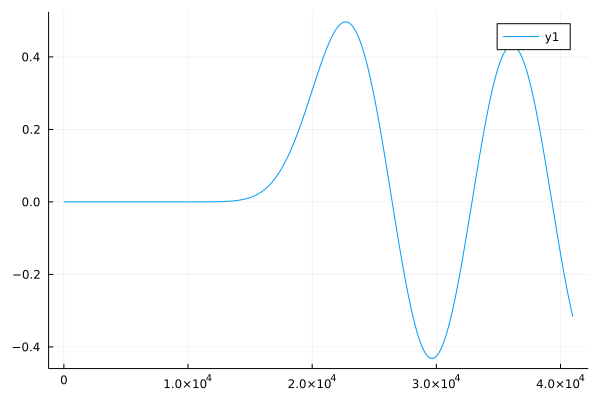

┌ Warning: Module JLLWrappers with build ID 5368472047828667 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing Libglvnd_jll [7e76a0d4-f3c7-5321-8279-8d96eeed0f29].
└ @ Base loading.jl:1047


In [3]:
function multiple_moving_average(x::AbstractArray,M::Integer, n_times::Integer)
    x0 = rect(M)/M
    for i in 1: n_times
        x0 = conv(x0, rect(M)/M)
    end
    conv(x,x0)[M ÷ 2 + 1 : length(x) + M÷2]

end
a = sin.(20*LinRange(0,1,41000))
plot(multiple_moving_average(a,2000,20))